# CNN - Modelling (Multi + Origin + Standalone TL)

# 1. Construct MLP 

In [1]:
import tensorflow as tf

%matplotlib inline

CLASS = "Mul"
PRE = "Ori"
TECH = "Standalone_TF"

print(tf.__version__)

2.4.2


In [2]:
! nvidia-smi

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Fri Sep  3 03:05:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   31C    P8     9W /  70W |      0MiB / 15109MiB |      0%    

Use MLP on the extracted features to make prediction.

In [3]:
from crack_utils import classification_block
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# define MLP model
def MLP(input_size):
    # define model input
    visible = Input(shape=(input_size, ))
    # add classification block
    layer = classification_block(visible, 32, classes=5)
    # create model
    model = Model(inputs=visible, outputs=layer)
    return model

# 2. Pretrain Model as Standalone Feature Extractor 

Use all layes previous to the output layer.

## 2.1 VGG19


In [4]:
from tensorflow.keras.applications import VGG19

# create model instance
model = VGG19()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

Extension horovod.torch has not been built: /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2021-09-03 03:05:18.985 ip-172-31-5-51:8176 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-09-03 03:05:19.057 ip-172-31-5-51:8176 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


Preprocess images and extract features: Due to the insufficient memory issue, we extract the features in 10 batches:

In [5]:
from crack_utils import load_multi_dataset, extract_in_batch, augment_data
from tensorflow.keras.applications.vgg19 import preprocess_input as pre_vgg19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np

SRC_MULTI = "/home/ubuntu/crack/Origin-Multi"

x_train, x_test, y_train, y_test = load_multi_dataset(SRC_MULTI, (224, 224))

np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4]), array([1158,  716,  484,  100,   83]))

In [6]:
from crack_utils import augment_data, add_noise_data

gen_temp = ImageDataGenerator()
x_train, y_train = augment_data(x_train, y_train, gen_temp)
x_train, y_train = add_noise_data(x_train, y_train)

np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4]), array([1158, 1158, 1158, 1158, 1158]))

In [7]:
x_train = extract_in_batch(20, x_train, model, "train", pre_vgg19)
x_test = extract_in_batch(10, x_test, model, "test", pre_vgg19)

# convert integers to dummy variables (i.e. one hot encoded)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

feature_length = x_train.shape[1]

Fit MLP model:

In [8]:
%%time

from crack_utils import multiple_compile

# create model instance
model = MLP(feature_length)
multiple_compile(model, 0.01, 0.9)

# fit the model
histories = dict()

model_name = "{}_{}_TL1_VGG19_aug_noised".format(CLASS, PRE)
histories[model_name] = model.fit(x=x_train, y=y_train, batch_size=64,
              validation_data=(x_test, y_test), epochs=30, verbose=0).history

CPU times: user 10 s, sys: 1.44 s, total: 11.4 s
Wall time: 7.4 s


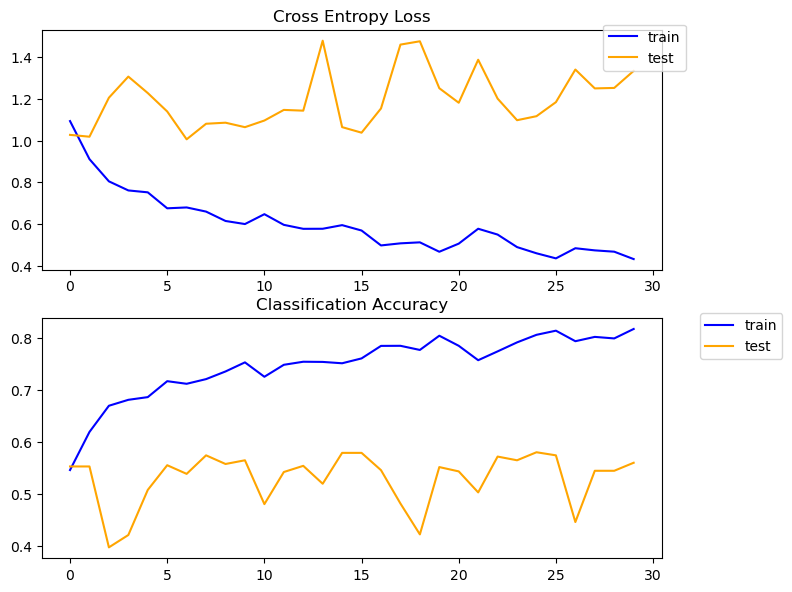

In [9]:
from crack_utils import summarize_diagnostics_multi
                                           
summarize_diagnostics_multi(histories[model_name], "model_plot/{}.png".format(model_name))

In [10]:
from crack_utils import show_result_multi

results = dict()

results[model_name] = show_result_multi(model, x_test, y_test, y_test)

Test loss: 1.33
Test accuracy: 0.56
Test f1 micro: 0.56
Test f1 macro: 0.48
Test f1 weighted: 0.48


## 2.2 ResNet152V2

In [11]:
from tensorflow.keras.applications import ResNet152V2

# create model instance
model = ResNet152V2()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

Preprocess images and extract features: Due to the insufficient memory issue, we extract the features in 10 batches:

In [12]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input as pre_resnet_v2

del x_train, x_test
x_train, x_test, y_train, y_test = load_multi_dataset(SRC_MULTI, (224, 224))

gen_temp = ImageDataGenerator()
x_train, y_train = augment_data(x_train, y_train, gen_temp)
x_train, y_train = add_noise_data(x_train, y_train)

x_train = extract_in_batch(20, x_train, model, "train", pre_resnet_v2)
x_test = extract_in_batch(10, x_test, model, "test", pre_resnet_v2)

# convert integers to dummy variables (i.e. one hot encoded)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

feature_length = x_train.shape[1]

Fit MLP model:

In [13]:
%%time

# create model instance
model = MLP(feature_length)
multiple_compile(model, 0.01, 0.9)

# fit the model
model_name = "{}_{}_TL1_ResNet152V2_aug_noised".format(CLASS, PRE)
histories[model_name] = model.fit(x=x_train, y=y_train, batch_size=64,
              validation_data=(x_test, y_test), epochs=30, verbose=0).history

CPU times: user 9.06 s, sys: 1.12 s, total: 10.2 s
Wall time: 6.22 s


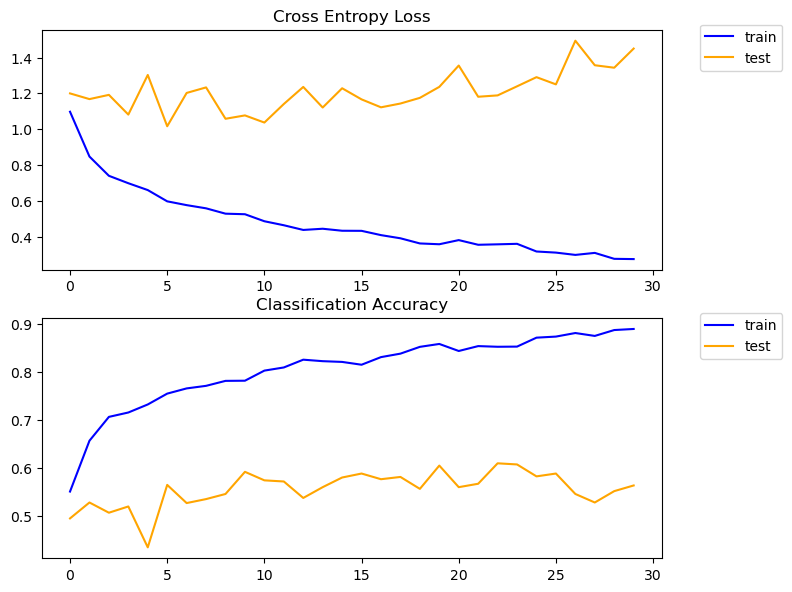

In [14]:
summarize_diagnostics_multi(histories[model_name], "model_plot/{}.png".format(model_name))

In [15]:
results[model_name] = show_result_multi(model, x_test, y_test, y_test)

Test loss: 1.45
Test accuracy: 0.56
Test f1 micro: 0.56
Test f1 macro: 0.56
Test f1 weighted: 0.56


## 2.3 DenseNet201

In [16]:
from tensorflow.keras.applications import DenseNet201

# create model instance
model = DenseNet201()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

Preprocess images and extract features: Due to the insufficient memory issue, we extract the features in 10 batches:

In [17]:
from tensorflow.keras.applications.densenet import preprocess_input as pre_densenet

# del x_train, x_test
x_train, x_test, y_train, y_test = load_multi_dataset(SRC_MULTI, (224, 224))

gen_temp = ImageDataGenerator()
x_train, y_train = augment_data(x_train, y_train, gen_temp)
x_train, y_train = add_noise_data(x_train, y_train)

x_train = extract_in_batch(20, x_train, model, "train", pre_densenet)
x_test = extract_in_batch(10, x_test, model, "test", pre_densenet)

# convert integers to dummy variables (i.e. one hot encoded)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

feature_length = x_train.shape[1]

Fit MLP model:

In [18]:
%%time

from crack_utils import binary_compile

# create model instance
model = MLP(feature_length)
multiple_compile(model, 0.01, 0.9)

# fit the model
model_name = "{}_{}_TL1_DenseNet201_aug_noised".format(CLASS, PRE)
histories[model_name] = model.fit(x=x_train, y=y_train, batch_size=64,
              validation_data=(x_test, y_test), epochs=30, verbose=0).history

CPU times: user 8.95 s, sys: 1.25 s, total: 10.2 s
Wall time: 6.24 s


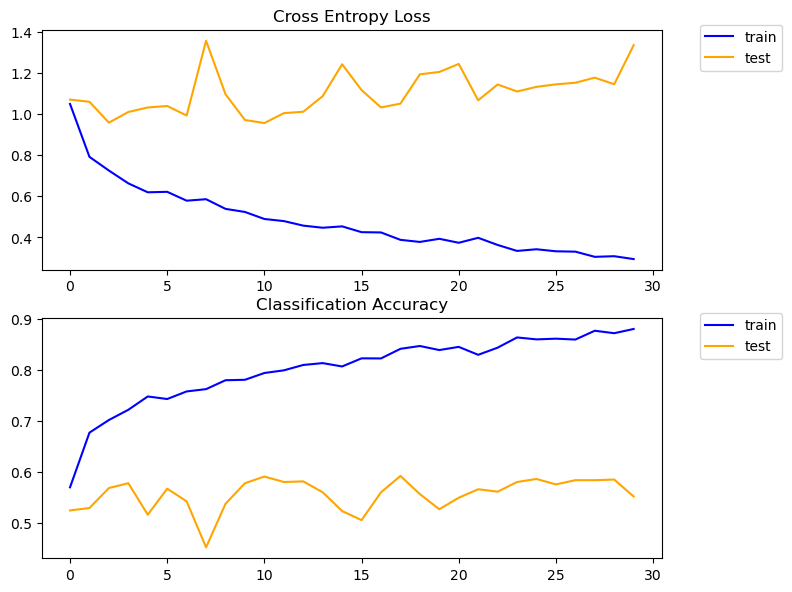

In [19]:
summarize_diagnostics_multi(histories[model_name], "model_plot/{}.png".format(model_name))

In [20]:
results[model_name] = show_result_multi(model, x_test, y_test, y_test)

Test loss: 1.33
Test accuracy: 0.55
Test f1 micro: 0.55
Test f1 macro: 0.52
Test f1 weighted: 0.54


# 3. Summary

Final result:

In [21]:
from crack_utils import get_final_result

get_final_result(results).round(2)

,Mul_Ori_TL1_VGG19_aug_noised,Mul_Ori_TL1_ResNet152V2_aug_noised,Mul_Ori_TL1_DenseNet201_aug_noised
Loss,1.33,1.45,1.33
Accuracy,0.56,0.56,0.55
F1 Micro,0.56,0.56,0.55
F1 Macro,0.48,0.56,0.52
F1 Weighted,0.48,0.56,0.54


Compare each model:

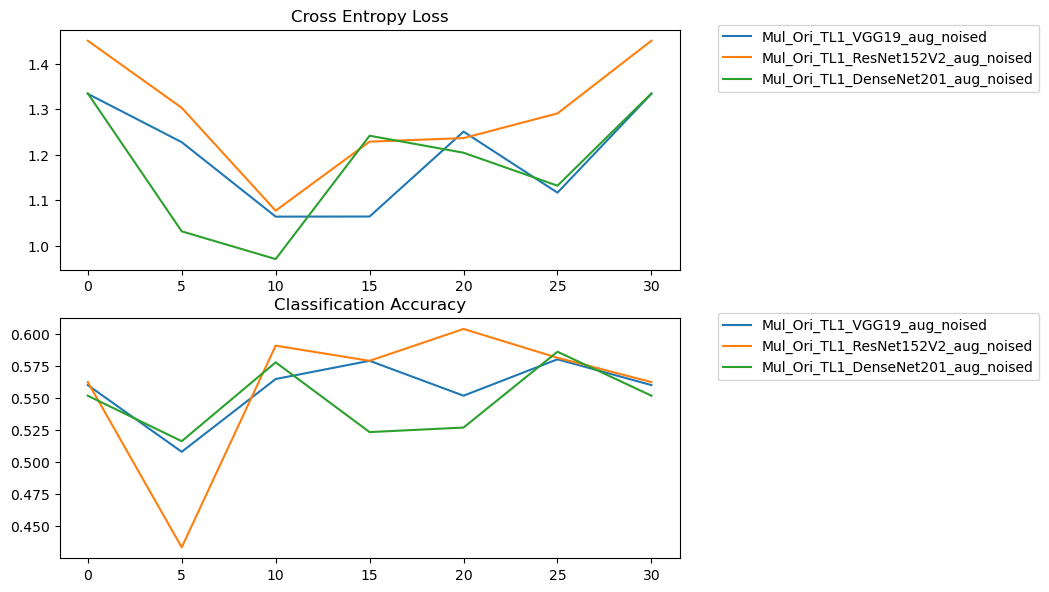

In [22]:
from crack_utils import compare_all_result_multi

compare_all_result_multi(histories, filename="model_plot/Compare_{}_{}_{}_aug.png".format(CLASS, PRE, TECH), end=30, step=5)

Save epochs history:

In [23]:
from crack_utils import save_history

save_history(histories, folder="epochs_history")